<a href="https://colab.research.google.com/github/j-winfield/fastaidl/blob/master/Satellite_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
! {sys.executable} -m pip install kaggle --upgrade


Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
mkdir -p ~/.kaggle/

In [0]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"befinbabu","key":"d6c5c525e3d29e7ef44073558afeebab"}'}

In [0]:
!cp kaggle.json ~/.kaggle/



In [8]:
ls

kaggle.json  sample_data/


In [9]:
path=Config.data_path()/'planet'
path.mkdir(parents=True,exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [10]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  

 99% 593M/600M [00:06<00:00, 30.5MB/s]
100% 600M/600M [00:07<00:00, 89.3MB/s]


In [11]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 47.4MB/s]


In [0]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


In [0]:
df=pd.read_csv(path/'train_v2.csv')

In [15]:
df.head

<bound method NDFrame.head of         image_name                                               tags
0          train_0                                       haze primary
1          train_1                    agriculture clear primary water
2          train_2                                      clear primary
3          train_3                                      clear primary
4          train_4          agriculture clear habitation primary road
5          train_5                                 haze primary water
6          train_6        agriculture clear cultivation primary water
7          train_7                                       haze primary
8          train_8              agriculture clear cultivation primary
9          train_9         agriculture clear cultivation primary road
10        train_10         agriculture clear primary slash_burn water
11        train_11                                clear primary water
12        train_12                                          

In [0]:
tfms=get_transforms(flip_vert=True,max_lighting=.1,max_zoom=1.05,max_warp=0.)

In [0]:
np.random.seed(42)
src=(ImageList.from_csv(path,'train_v2.csv',folder='train-jpg',suffix='.jpg').split_by_rand_pct(.2).label_from_df(label_delim=' '))

In [0]:
data=(src.transform(tfms,size=128).databunch().normalize(imagenet_stats))

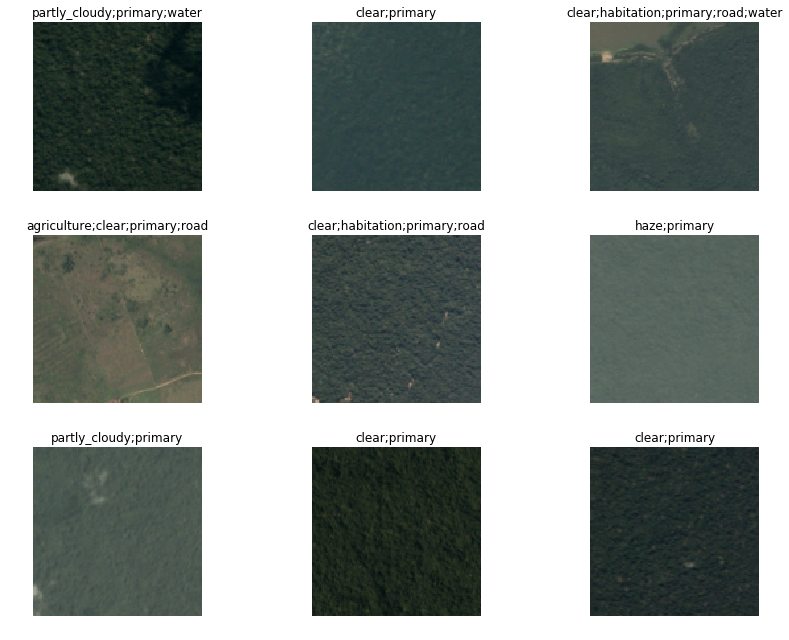

In [19]:
data.show_batch(rows=3,figsize=(12,9))

In [0]:
arch=models.resnet50

In [21]:
acc_02=partial(accuracy_thresh,thresh=0.2)
f_score=partial(fbeta,thresh=0.2)
learn=cnn_learner(data,arch,metrics=[acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.2MB/s]


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


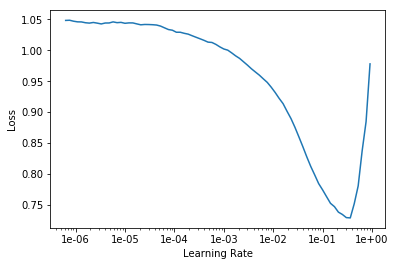

In [23]:
learn.recorder.plot()

In [0]:
lr=0.01

In [25]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.140311,0.115748,0.949671,0.900707,03:46
1,0.110838,0.099438,0.952978,0.914093,03:46
2,0.105785,0.092050,0.954736,0.920093,03:45
3,0.095394,0.087818,0.955332,0.924256,03:46
4,0.090526,0.086932,0.955782,0.925259,03:46


In [0]:
learn.save('stage-1-resnet50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


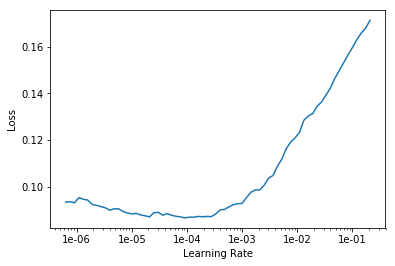

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5,slice(1e-05,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097983,0.091349,0.950805,0.922333,04:39
1,0.097609,0.089284,0.953435,0.922399,04:39
2,0.090251,0.085818,0.959089,0.925357,04:40
3,0.087023,0.083302,0.958268,0.927686,04:40
4,0.080742,0.082889,0.957890,0.928183,04:40


In [0]:
learn.save('stage-2-res50')

In [0]:
data=(src.transform(tfms,size=256).databunch().normalize(imagenet_stats))
learn.data=data

In [36]:
data.train_ds[0][0].shape


torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


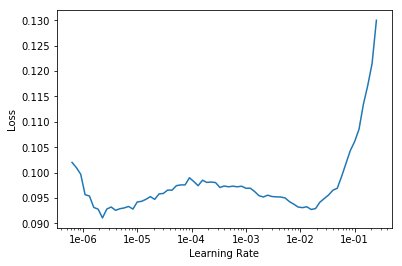

In [37]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [39]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086741,0.085732,0.957359,0.925585,11:21
1,0.087437,0.084319,0.957802,0.926745,11:18
2,0.085483,0.083102,0.956168,0.928234,11:17
3,0.082198,0.081497,0.958725,0.928765,11:17
4,0.078309,0.081014,0.959132,0.931020,11:16


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(5,slice(1e-05,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081403,0.084265,0.957250,0.925690,14:56
1,0.085869,0.083693,0.954307,0.926159,14:51
2,0.083304,0.083150,0.958733,0.927785,14:52


KeyboardInterrupt: ignored

In [0]:
learn.export()

In [47]:
path.ls()


[PosixPath('/root/.fastai/data/planet/models'),
 PosixPath('/root/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/root/.fastai/data/planet/train-jpg'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv'),
 PosixPath('/root/.fastai/data/planet/export.pkl'),
 PosixPath('/root/.fastai/data/planet/__MACOSX')]